In [120]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [121]:
#Load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [122]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [123]:
# Prepare data to be predicted
def prepare_data(df):
  df_aux = df.drop(columns=['Wind_Speed','Wind_Direction','Visibility','Cloud_Cover','Relative_Humidity','Rain','Clear','Partially_cloudy',
                            'confirmados_arsalentejo','confirmados_acores','confirmados_madeira','confirmados_novos','internados_uci','obitos_arsnorte',
                                'obitos_arslvt','obitos_arsalentejo',
       'obitos_arsalgarve', 'obitos_acores', 'obitos_madeira','ativos','confirmados_10_19','confirmados_70_79',
       'confirmados_80_plus', 'obitos_0_9', 'obitos_10_19', 'obitos_20_29',
       'obitos_30_39', 'obitos_40_49', 'obitos_50_59', 'obitos_60_69',
       'obitos_70_79', 'obitos_80_plus', 'Max_Temp', 'Min_Temp', 'Temperature',
       'Precipitation'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [124]:

#Normalize the data
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['confirmados']] = scaler.fit_transform(df[['confirmados']])
  df[['confirmados_arsnorte']] = scaler.fit_transform(df[['confirmados_arsnorte']])
  df[['confirmados_arscentro']] = scaler.fit_transform(df[['confirmados_arscentro']])
  df[['confirmados_arslvt']] = scaler.fit_transform(df[['confirmados_arslvt']])
  df[['confirmados_arsalgarve']] = scaler.fit_transform(df[['confirmados_arsalgarve']])
  df[['recuperados']] = scaler.fit_transform(df[['recuperados']])
  df[['obitos_arscentro']] = scaler.fit_transform(df[['obitos_arscentro']])
  df[['internados_enfermaria']] = scaler.fit_transform(df[['internados_enfermaria']])
  df[['confirmados_0_9']] = scaler.fit_transform(df[['confirmados_0_9']])
  df[['confirmados_20_29']] = scaler.fit_transform(df[['confirmados_20_29']])
  df[['confirmados_30_39']] = scaler.fit_transform(df[['confirmados_30_39']])
  df[['confirmados_40_49']] = scaler.fit_transform(df[['confirmados_40_49']])
  df[['confirmados_50_59']] = scaler.fit_transform(df[['confirmados_50_59']])
  df[['confirmados_60_69']] = scaler.fit_transform(df[['confirmados_60_69']])
  df[['obitos']] = scaler.fit_transform(df[['obitos']])

  return scaler

In [125]:
#plot learning curve
def plot_learning_curves(history, epochs):
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [126]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Deaths')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [127]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 10])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [128]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dense(1, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'covid_model.png', show_shapes=True)
  return model

In [129]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas)
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [130]:
  # Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = np.array(df[-timesteps:].values)  # getting the last sequence of known value
    inp = input_seq
    # print("Input_seq: ",inp)
    forecasts = list()

    # multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
    for step in range(1, multisteps + 1):
      inp = inp.reshape(1, timesteps, n_variate)
      yhat = model.predict(inp)  # dá o valor predito normalizado
      yhat_desnormalized = scaler.inverse_transform(yhat)  # dá valor predito desnormalizado
      forecasts.append(yhat_desnormalized)  # adicionar previsao à lista final de previsões

    return forecasts

In [131]:
def plot_forecast(data, forecasts):

    plt.figure(figsize=(8, 6))
    plt.plot(range(len(data)), data['obitos'], color='green', label='True value')
    plt.plot(range(len(data) - 1, len(data) + len(forecasts) - 1), forecasts, color='red', label='Forecasts')
    plt.title('Number of deaths')
    plt.ylabel('Value')
    plt.xlabel('Days')
    plt.legend()
    plt.show()

Index(['confirmados', 'confirmados_arsnorte', 'confirmados_arscentro',
       'confirmados_arslvt', 'confirmados_arsalgarve', 'recuperados', 'obitos',
       'obitos_arscentro', 'internados_enfermaria', 'confirmados_0_9',
       'confirmados_20_29', 'confirmados_30_39', 'confirmados_40_49',
       'confirmados_50_59', 'confirmados_60_69'],
      dtype='object')
(422, 15)
Epoch 1/10
19/19 [==============================] - 5s 72ms/step - loss: 0.4389 - mae: 0.4389 - rmse: 0.4388 - val_loss: 0.0781 - val_mae: 0.0781 - val_rmse: 0.0781
Epoch 2/10
19/19 [==============================] - 0s 11ms/step - loss: 0.0228 - mae: 0.0228 - rmse: 0.0228 - val_loss: 0.0228 - val_mae: 0.0228 - val_rmse: 0.0228
Epoch 3/10
19/19 [==============================] - 0s 11ms/step - loss: 0.0208 - mae: 0.0208 - rmse: 0.0208 - val_loss: 0.0240 - val_mae: 0.0240 - val_rmse: 0.0240
Epoch 4/10
19/19 [==============================] - 0s 11ms/step - loss: 0.0337 - mae: 0.0337 - rmse: 0.0337 - val_loss: 0.0318 - v

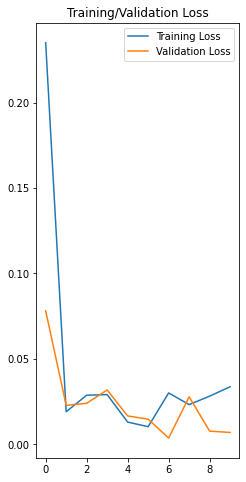

Epoch 1/10
38/38 [==============================] - 0s 11ms/step - loss: 0.0207 - mae: 0.0206 - rmse: 0.0207 - val_loss: 0.0226 - val_mae: 0.0225 - val_rmse: 0.0226
Epoch 2/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0440 - mae: 0.0440 - rmse: 0.0435 - val_loss: 0.0157 - val_mae: 0.0155 - val_rmse: 0.0157
Epoch 3/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0674 - mae: 0.0673 - rmse: 0.0664 - val_loss: 0.0297 - val_mae: 0.0296 - val_rmse: 0.0297
Epoch 4/10
38/38 [==============================] - 0s 9ms/step - loss: 0.0249 - mae: 0.0248 - rmse: 0.0246 - val_loss: 0.0100 - val_mae: 0.0096 - val_rmse: 0.0100
Epoch 5/10
38/38 [==============================] - 0s 9ms/step - loss: 0.0402 - mae: 0.0401 - rmse: 0.0398 - val_loss: 0.0087 - val_mae: 0.0084 - val_rmse: 0.0087

Epoch 00005: val_loss did not improve from 0.00691
Epoch 6/10
38/38 [==============================] - 0s 10ms/step - loss: 0.0525 - mae: 0.0525 - rmse: 0.0520 - val_loss: 0.03

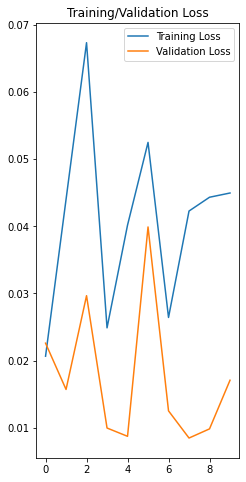

Epoch 1/10
56/56 [==============================] - 1s 10ms/step - loss: 0.0427 - mae: 0.0425 - rmse: 0.0428 - val_loss: 0.1457 - val_mae: 0.1449 - val_rmse: 0.1608
Epoch 2/10
56/56 [==============================] - 1s 9ms/step - loss: 0.1609 - mae: 0.1605 - rmse: 0.1604 - val_loss: 0.1253 - val_mae: 0.1244 - val_rmse: 0.1394
Epoch 3/10
56/56 [==============================] - 1s 9ms/step - loss: 0.2416 - mae: 0.2415 - rmse: 0.2410 - val_loss: 0.1493 - val_mae: 0.1488 - val_rmse: 0.1616
Epoch 4/10
56/56 [==============================] - 1s 9ms/step - loss: 0.2071 - mae: 0.2070 - rmse: 0.2068 - val_loss: 0.1551 - val_mae: 0.1548 - val_rmse: 0.1645
Epoch 5/10
56/56 [==============================] - 1s 9ms/step - loss: 0.1579 - mae: 0.1577 - rmse: 0.1573 - val_loss: 0.0694 - val_mae: 0.0686 - val_rmse: 0.0820

Epoch 00005: val_loss did not improve from 0.00691
Epoch 6/10
56/56 [==============================] - 1s 9ms/step - loss: 0.1614 - mae: 0.1613 - rmse: 0.1610 - val_loss: 0.0416 

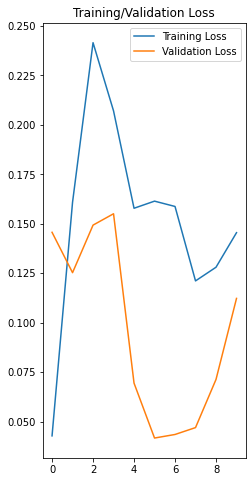

[array([[7623.8433]], dtype=float32)]


In [132]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

#Number os variables to use
n_variate = 15
#the dataframes
path=r'daily_covid.csv'
df_raw = load_dataset(path)
df_data = prepare_data(df_raw)
df = df_data.copy()

print(df.columns)

print(df.shape)

scaler = data_normalization(df) #scaling data to [-1, 1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 }#,
                  #2: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  #3: {'timesteps' : 7, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  #
                  #4: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  #5: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  #6: {'timesteps' : 8, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  #
                  #7: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  #8: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  #9: {'timesteps' : 10, 'multisteps' : 1, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)

   print(forecasts)

   prev = []

    # plot do valor previsto da ação de Open
    #for f in forecasts:
    #  prev.append(f[0][0])

    #print(prev)
    #plot_forecast(df_raw, prev)


   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [133]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.07942939950153231, 0.07935897170876463, 0.07908178130164742, 0.045624028208355115, 0.04521075935723881, 0.04965185138086478] 



,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.079429,0.079359,0.079082,0.045624,0.045211,0.049652


In [135]:
#Results metrics to a file
final_df.to_csv(r"resultados_lstm_covid.csv",index=True)